
Training Vanilla GPT...


Epoch 1: 100%|██████████| 24/24 [00:06<00:00,  4.00it/s]


Epoch 1 Loss: 9.7825


Epoch 2: 100%|██████████| 24/24 [00:05<00:00,  4.22it/s]


Epoch 2 Loss: 7.7361


Epoch 3: 100%|██████████| 24/24 [00:04<00:00,  4.89it/s]


Epoch 3 Loss: 5.9231


Epoch 4: 100%|██████████| 24/24 [00:04<00:00,  4.84it/s]


Epoch 4 Loss: 4.0605


Epoch 5: 100%|██████████| 24/24 [00:05<00:00,  4.25it/s]


Epoch 5 Loss: 2.9458

Training GPT with CLS_TOKEN...


Epoch 1: 100%|██████████| 24/24 [00:05<00:00,  4.52it/s]


Epoch 1 Loss: 8.1447


Epoch 2: 100%|██████████| 24/24 [00:06<00:00,  3.93it/s]


Epoch 2 Loss: 5.8567


Epoch 3: 100%|██████████| 24/24 [00:05<00:00,  4.54it/s]


Epoch 3 Loss: 3.4214


Epoch 4: 100%|██████████| 24/24 [00:06<00:00,  3.56it/s]


Epoch 4 Loss: 2.5913


Epoch 5: 100%|██████████| 24/24 [00:05<00:00,  4.74it/s]


Epoch 5 Loss: 1.9286


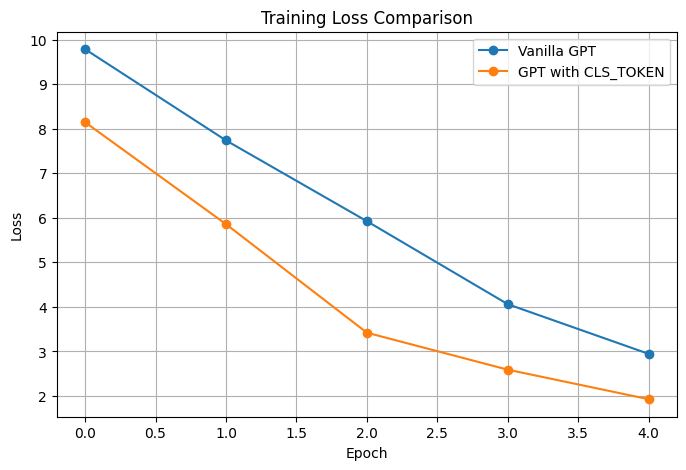

In [15]:
# !pip install tiktoken matplotlib

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import tiktoken
from tqdm import tqdm
import math
import matplotlib.pyplot as plt

# ============================
# Tokenizer
# ============================
encoding = tiktoken.get_encoding("gpt2")
eot_token = encoding.encode("<|endoftext|>", allowed_special={"<|endoftext|>"})[0]

text_data = [
    "Hello world this is GPT demo",
    "I am learning transformers",
    "PyTorch makes it easy",
    "Causal masking is important",
    "Self attention is powerful",
    "Feed forward layers help",
    "Normalization stabilizes training",
    "Dropout prevents overfitting",
    "Token embeddings are essential",
    "Position embeddings add order"
]  # shortened for demo

# ============================
# Dataset
# ============================
class GPTDataset(Dataset):
    def __init__(self, data, block_size=16):
        self.block_size = block_size
        self.tokens = []
        for line in data:
            self.tokens.extend(encoding.encode(line) + [eot_token])

    def __len__(self):
        return len(self.tokens) - self.block_size

    def __getitem__(self, idx):
        x = torch.tensor(self.tokens[idx:idx+self.block_size], dtype=torch.long)
        y = torch.tensor(self.tokens[idx+1:idx+self.block_size+1], dtype=torch.long)
        return x, y

dataset = GPTDataset(text_data, block_size=16)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

# ============================
# GPT Config
# ============================
class GPTConfig:
    def __init__(self, vocab_size, block_size, n_layer=2, n_head=4, n_embd=128, dropout=0.1):
        self.vocab_size = vocab_size
        self.block_size = block_size
        self.n_layer = n_layer
        self.n_head = n_head
        self.n_embd = n_embd
        self.dropout = dropout

# ============================
# Components
# ============================
class CasualSelfAttention(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        self.n_head = config.n_head
        self.head_dim = config.n_embd // config.n_head
        self.c_attn = nn.Linear(config.n_embd, 3*config.n_embd)
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size)).view(1,1,config.block_size,config.block_size))

    def forward(self, x):
        B,T,C = x.size()
        q,k,v = self.c_attn(x).split(C, dim=2)
        q = q.view(B,T,self.n_head,self.head_dim).transpose(1,2)
        k = k.view(B,T,self.n_head,self.head_dim).transpose(1,2)
        v = v.view(B,T,self.n_head,self.head_dim).transpose(1,2)
        att = (q @ k.transpose(-2,-1)) * (1.0/math.sqrt(self.head_dim))
        att = att.masked_fill(self.bias[:,:,:T,:T]==0, float('-inf'))
        att = F.softmax(att, dim=-1)
        att = self.attn_dropout(att)
        y = att @ v
        y = y.transpose(1,2).contiguous().view(B,T,C)
        y = self.resid_dropout(self.c_proj(y))
        return y

class CasualSelfAttention2(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        self.n_head = config.n_head
        self.head_dim = config.n_embd // config.n_head
        self.c_attn = nn.Linear(config.n_embd, 3*config.n_embd)
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.register_buffer("bias", torch.tril(torch.ones(config.block_size+1, config.block_size+1)).view(1,1,config.block_size+1,config.block_size+1))

    def forward(self, x):
        B,T,C = x.size()
        q,k,v = self.c_attn(x).split(C, dim=2)
        q = q.view(B,T,self.n_head,self.head_dim).transpose(1,2)
        k = k.view(B,T,self.n_head,self.head_dim).transpose(1,2)
        v = v.view(B,T,self.n_head,self.head_dim).transpose(1,2)
        att = (q @ k.transpose(-2,-1)) * (1.0/math.sqrt(self.head_dim))
        att = att.masked_fill(self.bias[:,:,:T,:T]==0, float('-inf'))
        att = F.softmax(att, dim=-1)
        att = self.attn_dropout(att)
        y = att @ v
        y = y.transpose(1,2).contiguous().view(B,T,C)
        y = self.resid_dropout(self.c_proj(y))
        return y


class MLP(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.c_fc = nn.Linear(config.n_embd, 4*config.n_embd)
        self.c_proj = nn.Linear(4*config.n_embd, config.n_embd)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self,x):
        return self.dropout(self.c_proj(F.gelu(self.c_fc(x))))

class Block(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.ln1 = nn.LayerNorm(config.n_embd)
        self.attn = CasualSelfAttention(config)
        self.ln2 = nn.LayerNorm(config.n_embd)
        self.ff = MLP(config)

    def forward(self,x):
        x = x + self.attn(self.ln1(x))
        x = x + self.ff(self.ln2(x))
        return x


class Block2(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.ln1 = nn.LayerNorm(config.n_embd)
        self.attn = CasualSelfAttention2(config)
        self.ln2 = nn.LayerNorm(config.n_embd)
        self.ff = MLP(config)

    def forward(self,x):
        x = x + self.attn(self.ln1(x))
        x = x + self.ff(self.ln2(x))
        return x
# ============================
# Model 1: Vanilla GPT
# ============================
class GPTVanilla(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.config = config
        self.tok_emb = nn.Embedding(config.vocab_size, config.n_embd)
        self.pos_emb = nn.Embedding(config.block_size, config.n_embd)
        self.drop = nn.Dropout(config.dropout)
        self.blocks = nn.ModuleList([Block(config) for _ in range(config.n_layer)])
        self.ln_f = nn.LayerNorm(config.n_embd)
        self.head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

    def forward(self, idx, targets=None):
        B,T = idx.size()
        pos = torch.arange(0,T,device=idx.device).unsqueeze(0)
        x = self.tok_emb(idx) + self.pos_emb(pos)
        x = self.drop(x)
        for block in self.blocks:
            x = block(x)
        x = self.ln_f(x)
        logits = self.head(x)
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
        return logits, loss


class GPT_CLS_TOKEN(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.config = config
        self.cls_token=nn.Parameter(torch.randn(1,1,config.n_embd))
        self.tok_emb = nn.Embedding(config.vocab_size, config.n_embd)
        self.pos_emb = nn.Embedding(config.block_size+1, config.n_embd)
        self.drop = nn.Dropout(config.dropout)
        self.blocks = nn.ModuleList([Block2(config) for _ in range(config.n_layer)])
        self.ln_f = nn.LayerNorm(config.n_embd)
        self.head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

    def forward(self, ids, targets=None):
        B,T = ids.size()
        cls_token=self.cls_token.expand(B,-1,-1)
        pos=torch.arange(0,T+1,dtype=torch.long,device=ids.device).unsqueeze(0)
        emb_ids=torch.concat([cls_token,self.tok_emb(ids)],dim=1)
        emb_ids+=self.pos_emb(pos)
        x=self.drop(emb_ids)
        for block in self.blocks:
            x = block(x)
        x = self.ln_f(x)
        logits=self.head(x)
        cls_logit=logits[:,0,:].unsqueeze(1)
        logits=logits[:,1:T+1,:]+cls_logit.expand(B,T,-1)
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
        return logits, loss

# ============================
# Train function
# ============================
def train_model(model, dataloader, epochs=5, lr=3e-4):
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    model.train()
    losses = []
    for epoch in range(epochs):
        for xb, yb in tqdm(dataloader, desc=f"Epoch {epoch+1}"):
            logits, loss = model(xb, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1} Loss: {loss.item():.4f}")
        losses.append(loss.item())
    return losses

# ============================
# Initialize models
# ============================
vocab_size = encoding.n_vocab
config = GPTConfig(vocab_size=vocab_size, block_size=16)

model_vanilla = GPTVanilla(config)
model_cls = GPT_CLS_TOKEN(config)

# ============================
# Train both models
# ============================
print("\nTraining Vanilla GPT...")
loss_vanilla = train_model(model_vanilla, dataloader)

print("\nTraining GPT with CLS_TOKEN...")
loss_premlp = train_model(model_cls, dataloader)

# ============================
# Plot Loss Curves
# ============================
plt.figure(figsize=(8,5))
plt.plot(loss_vanilla, label="Vanilla GPT", marker='o')
plt.plot(loss_premlp, label="GPT with CLS_TOKEN", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Comparison")
plt.legend()
plt.grid(True)
plt.show()


In [16]:
def count_para(model:nn.Module):
  trainable_para=sum(p.numel() for p in model.parameters())
  print(f"Total Trainable Parameters:{trainable_para:,}")

In [17]:
count_para(model_vanilla)
count_para(model_cls)

Total Trainable Parameters:13,264,640
Total Trainable Parameters:13,264,896
